In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [6]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
    
aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
# import node
# import link
# #import quadraticassignmentcyt
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [7]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [57]:
%%time
scenario = "Berlin-Center" #"Anaheim" #
num_iters = 8
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
bch.get_data_structure_with_by_directional_links()
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it


### Iterations
od_path_times = {}
shortest_path_time = 0
opt_setup_time = 0
opt_solv_time = 0
update_time = 0
total_time = 0
for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        t4 = time.time()
        t_assignment.update_path_flows(origin, solution)
        t5 = time.time()
        shortest_path_time += t2 - t1
        opt_setup_time += t3 - t2
        opt_solv_time += t4 - t3
        update_time += t5 - t4
        total_time += t5 - t1
        
    print(f"  {datetime.now()} - solved P(r) for all r and updated path flows")
    print(f"    runtime breakdown: dijkstra = {shortest_path_time:.2f}, opt setup = {opt_setup_time:.2f}, opt solver = {opt_solv_time:.2f}, update = {update_time:.2f}")
    print(f"                       dijkstra = {shortest_path_time/total_time:.0%}, opt setup = {opt_setup_time/total_time:.0%}, opt solver = {opt_solv_time/total_time:.0%}, update = {update_time/total_time:.0%}")
    

    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)
    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")
print(f"{datetime.now()} - Done")

# Collect results
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-04 12:03:56.092994 - Running scenario Berlin-Center
2020-12-04 12:03:56.802864 - num nodes = 12981, num links = 28370
2020-12-04 12:03:59.156116 - performing initial solution
  2020-12-04 12:04:09.906244 - starting iteration 0
  2020-12-04 12:04:45.209156 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 9.03, opt setup = 6.27, opt solver = 10.22, update = 9.77
                       dijkstra = 26%, opt setup = 18%, opt solver = 29%, update = 28%
  2020-12-04 12:04:45.409226 - computed path times and flows, computed gap: 0.03523369394561715, computed objective: 13572901.0
  2020-12-04 12:04:45.409587 - starting iteration 1
  2020-12-04 12:05:24.943208 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 19.03, opt setup = 14.01, opt solver = 21.98, update = 19.80
                       dijkstra = 25%, opt setup = 19%, opt solver = 29%, update = 26%
  2020-12-04 12:05:25.157479 - computed path times and flows, computed g

CPU times: user 9min 29s, sys: 5.78 s, total: 9min 34s
Wall time: 1min 25s


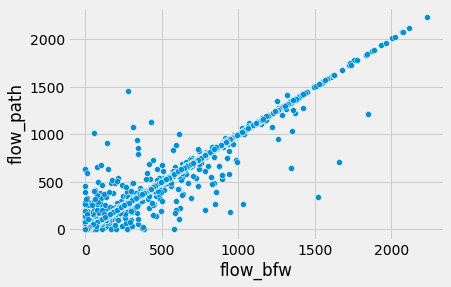

In [58]:
%%time
compare_flows = True
if compare_flows:
    bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)
    #I think time in bfw_result is free_flow_time
    full_result = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
    sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');

# dev

it seems like link flows get updated on each iteration, so we cannot parallelise the origins we loop over here, right?

Try doing it differently here and see what the results are.

In [59]:
%%time

bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes,ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)

print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")

bch.get_data_structure_with_by_directional_links()
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1
    
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()

costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it
od_path_times = {}

solutions_per_origin = {}

shortest_path_time = 0
opt_setup_time = 0
opt_solv_time = 0
update_time = 0
total_time = 0
for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        t2 = time.time()
        shortest_path_time += t2 - t1
    
    print(f"  {datetime.now()} - dijsktra done")
    
    for origin in origins:
#        t1 = time.time()
#        t_assignment.compute_shortest_paths(origin)
        t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        t4 = time.time()
        solutions_per_origin[origin] = solution
        t_assignment.update_path_flows(origin, solution)
        t5 = time.time()

        opt_setup_time += t3 - t2
        opt_solv_time += t4 - t3
        update_time += t5 - t4
        #total_time += t5 - t1
#     print(f"  {datetime.now()} - qp done")

#     for origin in origins:
#         t4 = time.time()
#         t_assignment.update_path_flows(origin, solutions_per_origin[origin])
#         t5 = time.time()
#         update_time += t5 - t4
    print(f"  {datetime.now()} - update done")
        
    total_time = shortest_path_time + opt_setup_time + opt_solv_time + update_time
        
    print(f"  {datetime.now()} - solved P(r) for all r and updated path flows")
    print(f"    runtime breakdown: dijkstra = {shortest_path_time:.2f}, opt setup = {opt_setup_time:.2f}, opt solver = {opt_solv_time:.2f}, update = {update_time:.2f}")
    print(f"                       dijkstra = {shortest_path_time/total_time:.0%}, opt setup = {opt_setup_time/total_time:.0%}, opt solver = {opt_solv_time/total_time:.0%}, update = {update_time/total_time:.0%}")
    

    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)

    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")

print(f"{datetime.now()} - Done")
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_dev = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-04 12:11:56.677636 - num nodes = 12981, num links = 28370
2020-12-04 12:11:59.441829 - performing initial solution
  2020-12-04 12:12:10.288478 - starting iteration 0
  2020-12-04 12:12:14.960220 - dijsktra done
  2020-12-04 12:12:43.395992 - update done
  2020-12-04 12:12:43.396219 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 4.67, opt setup = 7.19, opt solver = 11.57, update = 9.67
                       dijkstra = 14%, opt setup = 22%, opt solver = 35%, update = 29%
  2020-12-04 12:12:43.625094 - computed path times and flows, computed gap: 0.03996837733663039, computed objective: 13612985.0
  2020-12-04 12:12:43.625580 - starting iteration 1
  2020-12-04 12:12:48.640586 - dijsktra done
  2020-12-04 12:13:21.436068 - update done
  2020-12-04 12:13:21.436242 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 9.68, opt setup = 16.17, opt solver = 25.22, update = 19.82
                       dijkstra = 14%, opt s

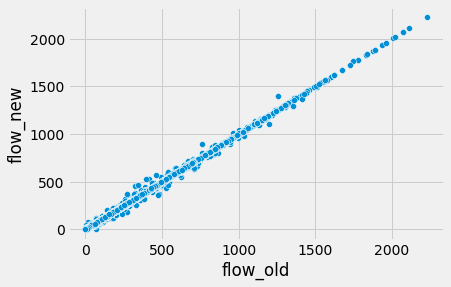

In [64]:
d_ = res_.merge(res_dev, on=['a_node', 'b_node'], how="outer", suffixes=["_old", "_new"])
d_ = d_.drop(columns=['time_old', 'time_new'])
sns.scatterplot(data=d_, x="flow_old", y="flow_new");

In [65]:
d_['abs_change'] = np.abs(d_.flow_old - d_.flow_new)
d_['rel_change'] = d_['abs_change'] / d_['flow_old']
print(f"max diff in flow = {d_['abs_change'].max()}")
print(f"max rel diff in flow = {d_['rel_change'].min()}")

max diff in flow = 138.4508056640625
max rel diff in flow = -10302886.20418407


max diff in flow = 143.1617431640625
max rel diff in flow = -1061708.2159524676


In [70]:
d_.sort_values(by=['abs_change'], ascending=False).head(20)

,a_node,b_node,flow_old,flow_new,abs_change,rel_change
485,98,10893,1259.074341,1397.525146,138.450806,0.109962
24072,10893,106,1259.074341,1397.525146,138.450806,0.109962
24091,10901,106,395.980621,531.844788,135.864166,0.343108
25807,11718,98,758.494629,892.828979,134.334351,0.177107
487,98,11718,324.720215,456.233978,131.513763,0.405006
24101,10904,104,342.177002,463.128601,120.951599,0.353477
528,106,10904,342.177002,463.128601,120.951599,0.353477
453,91,10316,483.806458,373.460327,110.346130,0.228079
22820,10316,88,472.763245,362.417358,110.345886,0.233406
454,91,10318,417.398010,524.753174,107.355164,0.257201


,a_node,b_node,flow_old,flow_new,abs_change,rel_change
25,6,11016,475.669312,440.543213,35.126099,0.073846
313,63,9046,177.035034,95.352882,81.682152,0.461390
314,63,9879,626.226562,546.240601,79.985962,0.127727
316,64,9043,537.589966,474.498322,63.091644,0.117360
333,67,9879,712.036926,632.738281,79.298645,0.111369


In [63]:
# full_result = bfw_res_.drop(columns=['time']).merge(d_, on=['a_node', 'b_node'], how='outer')
# sns.scatterplot(data=full_result, x='flow', y='flow_old');
# sns.scatterplot(data=full_result, x='flow', y='flow_new');